In [1]:
from Functions.polygon_scrape import *
from Functions.RF_Funcs import *
import pandas as pd
import numpy as np
from secret import polygon_key
from datetime import datetime, date
import polygon as pg
import warnings
warnings.filterwarnings('ignore')
import time

In [2]:
import pandas_market_calendars as mcal
nyse = mcal.get_calendar('NYSE')
start_date = '2020-01-01'
end_date = '2023-12-31'
schedule = nyse.schedule(start_date=start_date, end_date=end_date)
trading_days = schedule['market_open'].dt.date.tolist()

In [3]:
data = pd.read_csv('Data/Treasury.csv')
returns_data = pd.read_csv('Data/Return_Data.csv').set_index('date')

### Acquire Model Predictions

#### HAR

In [4]:
#Set date range to 2016 data = data[]

# X = data[['RV_(t-1)','RV_t Weekly', 'RV_t Monthly']]
# Y = data['RV_t (Realized Variance)']

# op = RollingWindowHAR(X,Y,data['date'])
# pred = np.sqrt(op['predictions'].loc['values'])*np.sqrt(365)
# df = pd.DataFrame(data=pred,index=data['date'][300:])
# df.to_csv('Data/predictions_HAR.csv')

#### Random Forests

MSE Optimization

In [5]:
# X = data[['RV_(t-1)','RV_t Weekly', 'RV_t Monthly',
#           'r_(t-1)', 'r_t Weekly', 'r_t Monthly',
#           'VIX Close (t-1)', '1MT (t-1)']]
# Y = data['RV_t (Realized Variance)']

# X['1MT (t-1)'] = pd.to_numeric(X['1MT (t-1)'], errors='coerce')
# X['1MT (t-1)'] = X['1MT (t-1)'].fillna((X['1MT (t-1)'].shift(+1) + X['1MT (t-1)'].shift(-1)) / 2)

# op = RollingWindowRF(X,Y,data['date'])
# pred = np.sqrt(op['predictions'].loc['values'])*np.sqrt(365)
# df = pd.DataFrame(data=pred,index=data['date'][300:])
# df.to_csv('Data/predictions_RF.csv')

MAE Optimization

In [6]:
# op = RollingWindowRF(X[-330:].reset_index(drop=True),Y[-330:].reset_index(drop=True),data['date'][-330:].reset_index(drop=True),w=150,method='mae')
# pred = np.sqrt(op['predictions'].loc['values'])*np.sqrt(365)

# df = pd.DataFrame(data=pred,index=data['date'][-180:])
# df.to_csv('Data/predictions_RF_MAE.csv')

### Import data to avoid long runtime

In [7]:
pred_RF = pd.read_csv('Data/predictions_RF.csv').set_index('date')
pred_RF_MAE = pd.read_csv('Data/predictions_RF_MAE.csv').set_index('date')
pred_HAR = pd.read_csv('Data/predictions_HAR.csv').set_index('date')

### Deploy the Option Strategy Using the Prediction

In [8]:
dates = data['date'].iloc[-180:]

[result_HAR,return_HAR_time] = RunStrategy(pred_HAR, dates, trading_days,results_data=returns_data,analysis=True)
[result_RF,return_RF_time] = RunStrategy(pred_RF, dates, trading_days,results_data=returns_data,analysis=True)
[result_RF_MAE,return_RF_MAE_time] = RunStrategy(pred_RF_MAE, dates, trading_days,results_data=returns_data,analysis=True)

Total return from 11/21/22-8/10/23: 2269%. Average daily return: 12.61%. Daily return variance: 90.6. Fraction of days when strategy is bought: 0.7389
Total return from 11/21/22-8/10/23: 1197%. Average daily return: 6.65%. Daily return variance: 91.23. Fraction of days when strategy is bought: 0.5333
Total return from 11/21/22-8/10/23: 1966%. Average daily return: 10.92%. Daily return variance: 90.82. Fraction of days when strategy is bought: 0.6167


### Examine Results

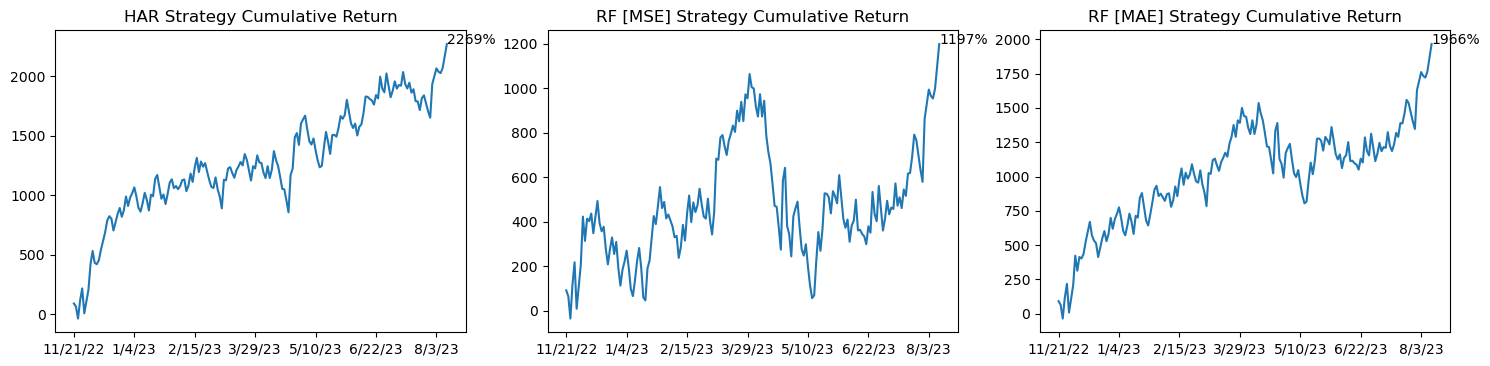

In [9]:
plots = [return_HAR_time,return_RF_time,return_RF_MAE_time]
title = ['HAR','RF [MSE]', 'RF [MAE]']

fig, ax = plt.subplots(1,3,figsize=(18,4),dpi=100)

for i, val in enumerate(plots):
    ax[i].plot(dates,val)
    ax[i].set_xticks(dates[::29])
    ax[i].set_title(f'{title[i]} Strategy Cumulative Return')
    ax[i].annotate(f'{int(plots[i][-1])}%', (dates.iloc[-1],plots[i][-1]))
    
plt.show()

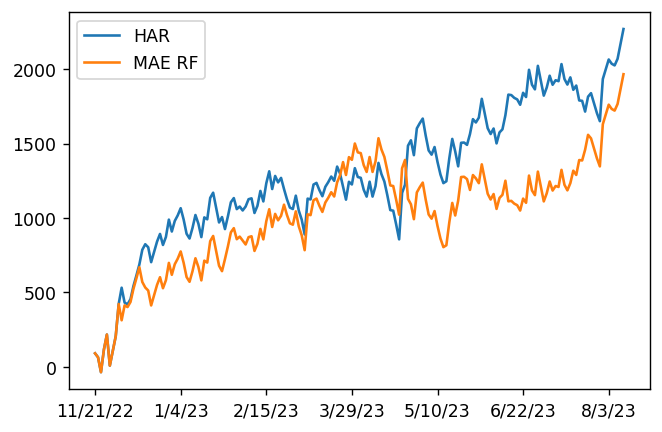

In [16]:
plt.figure(figsize=(6,4),dpi=125)
plt.plot(dates,return_HAR_time,label='HAR')
plt.plot(dates,return_RF_MAE_time,label='MAE RF')
plt.xticks(dates[::29])
plt.legend()
plt.show()

Extract the pulled ATM call/put average IV and the option strategy return

In [10]:
# Results = pd.DataFrame(index=dates, columns=['Avg IV','Return [%]'])

# for i, date in enumerate(dates):
#     if pred_RF_MAE[i] > result_RF_MAE[i]['Results']['Avg IV']:
#         signal = 1
#     else:
#         signal = -1
    
#     Results.loc[date] = [result_RF_MAE[i]['Results']['Avg IV'], float(result_RF_MAE[i]['Return'][:-1]) * signal]

# Results.to_csv('Data/Return_Data.csv')